In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.0f}'.format

import numpy as np
import gc
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# OBJETIVO: 
Construir um modelo capaz de prever de forma satisfatória a quantidade total de entradas de uma determinada data/periodo no metrô de New York (considerando todas as estações). 

In [2]:
def load_data(lst_file):
    
    lst_df = []
    for file in lst_file:
        df =  pd.read_csv(file)
        lst_df.append(df)

    df = pd.concat(lst_df)
    df.columns = [col.upper() for col in df.columns] 

    del lst_df
    lst_df=0

    gc.collect()   
    
    return df

def prep_data(df):
    
    df = df.sort_values(['CA','UNIT','SCP','TIME']).reset_index(drop = True).dropna(axis=0)
    df = df.drop_duplicates().reset_index(drop = True).dropna(axis=0) 
    
    df['TIME_ORG'] = df['TIME']
    df['TIMESTAMP'] = pd.to_datetime(df['TIME'], format = '%Y-%m-%d %H:%M:%S')
    df['DATE'] = pd.to_datetime(df['TIME'], format = '%Y-%m-%d').map(lambda x: x.strftime('%Y-%m-%d'))
    df['TIME'] = df['TIME'].map(lambda x: x.split(' ')[1])
    df['INTERVAL'] = df['TIMESTAMP'] - df['TIMESTAMP'].shift(1)
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d')
    
    return df

def calc_diff(df):
    
    df['ID'] = df['CA'] +'_'+ df['UNIT'] +'_'+ df['SCP']
    
    df['NEW_ID'] = ~ (df['ID'] == df['ID'].shift(1))
    
    df = df[(df['NEW_ID'] == False)].drop('NEW_ID', axis=1)
    df['ENTRY_DIFF'] = df['ENTRIES'] - df['ENTRIES'].shift(1)
    df['EXIT_DIFF'] = df['EXITS'] - df['EXITS'].shift(1)
    
    return df

def check_exc_incos(df):
    
    df = df[(df['INTERVAL'] / pd.Timedelta('1 hour') > 3.5) & \
            (df['INTERVAL'] / pd.Timedelta('1 hour') < 4.5)]
    
    #filtrando somente entradas maior que zero
    df = df[ (df['ENTRY_DIFF']>=0) ]
    TX_CUT = 14400 * 1.30
    df = df[(df['ENTRY_DIFF'] < TX_CUT)]
    
    #filtrando somente saidas maior que zero
    df = df[ (df['EXIT_DIFF']>=0) ]
    TX_CUT = 14400*2 * 1.30
    df = df[(df['EXIT_DIFF'] < TX_CUT)]

    return df

In [3]:
def feat_eng(df):
    
    df = df[['ENTRY_DIFF']]
    df.columns = ['y']
    
    df["day"] = df.index.day
    df["weekday"] = df.index.weekday
    df['is_weekend'] = df.weekday.isin([5,6])*1
    
    days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    for day in days:
           df[day] = (df['weekday'] == days.index(day)).astype(int)
    df = df.drop('weekday', axis=1)
    
    from pandas.tseries.holiday import USFederalHolidayCalendar
    calendar = USFederalHolidayCalendar()
    holiday_index = calendar.holidays('2016') 
    
    df = df.join(pd.Series(1, index=holiday_index, name='holiday'))
    df['holiday'].fillna(0, inplace=True)
    
    # Adicionando valores de targets anteriores a determinada observação
    for i in range(1, 30):
        df["lag_{}".format(i)] = df.y.shift(i)
        
    # Matriz de Correlação
    corr_matrix = df.corr().abs()

    # Selecionando o trinângulo superior da matriz de correlação
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Filtrando variáveis com correlação maior do que 0.85
    to_drop = [column for column in upper.columns if any(upper[column] > 0.85)] 
    
    df = df.drop(df[to_drop], axis=1)
    
    return df

In [4]:
def plotMovingAverage(series, window):
    """
        Apresentando o volume e média móvel
    """

    myFmt = DateFormatter("%Y-%m")
    
    rolling_mean = series.rolling(window=window).mean()

    fig, ax = plt.subplots(figsize=(15,7))
    plt.title("Tamanho da janela da média móvel = {}".format(window))
    plt.plot(rolling_mean, "g", label="Média móvel")
    ax.set_xticklabels(series.index, rotation=45 )
    ax.xaxis.set_major_formatter(myFmt) 
    plt.plot(series[window:], label="Volume")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [5]:
def plotHist(s1, s2):
    """
        Apresentando histogramas
    """
    
    fig, ax = plt.subplots(1,3, figsize=(12,4), gridspec_kw={'wspace': 0.5})

    ax[0].hist(s1.apply(pd.Timedelta) / pd.Timedelta('1 hour'), bins=48)
    ax[0].set_title('Tempo intra-medição')
    ax[0].set_xlabel('Hora')
    ax[0].set_xticks(range(24)[::2])
    ax[0].set_xlim(0,24)
    ax[0].set_ylabel('Observações')

    ax[1].hist(s2.dropna() / pd.Timedelta('1 hour'), bins=50)
    ax[1].set_title('Intervalo das medições')
    ax[1].set_xlabel('Tamanho do intervalo (Horas)')
    ax[1].set_ylabel('Observações')

    ax[2].hist((df['INTERVAL'].dropna() / pd.Timedelta('1 hour')).loc[lambda x: x >100], bins=50)
    ax[2].set_title('Intervalo das medições maior do que 100')
    ax[2].set_xlabel('Tamanho do intervalo (Horas)')
    ax[2].set_ylabel('Observações')

    plt.show()

# 1. Carregando os dados

In [6]:
lst_file = ['2016.csv', '2017.csv']
df = load_data(lst_file)

In [7]:
df.head()

,TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2016-01-01 00:00:00,A002,R051,02-00-00,59 ST,NQR456,BMT,REGULAR,5477257,1848890
1,2016-01-01 00:00:00,A002,R051,02-00-01,59 ST,NQR456,BMT,REGULAR,5043156,1101348
2,2016-01-01 00:00:00,A002,R051,02-03-00,59 ST,NQR456,BMT,REGULAR,624029,2352788
3,2016-01-01 00:00:00,A002,R051,02-03-01,59 ST,NQR456,BMT,REGULAR,5006519,7904628
4,2016-01-01 00:00:00,A002,R051,02-03-02,59 ST,NQR456,BMT,REGULAR,4734413,6529179


In [8]:
df.shape

(17596816, 10)

In [9]:
df.describe()

,ENTRIES,EXITS
count,17596816,17596816
mean,36480892,29231991
std,198573434,178479653
min,0,0
25%,543954,272449
50%,2619705,1502109
75%,6650668,4699703
max,2147483520,2097169792


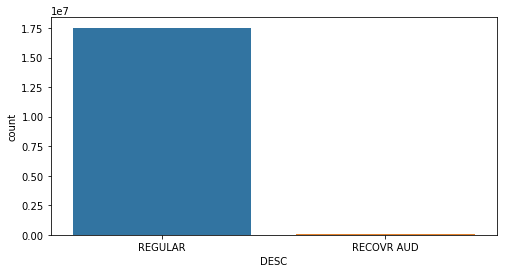

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(x='DESC', data=df)

Na descrição não foi informado nada a respeito dos valores do campo DESC, logo nenhuma manipulação e/ou filtro será feito no campo.

# 2. Preparando os dados

In [11]:
df = prep_data(df)

In [12]:
df.describe()

,ENTRIES,EXITS,INTERVAL
count,17596816,17596816,17596815
mean,36480892,29231991,0 days 00:00:03.050120
std,198573434,178479653,10 days 04:24:13.734897
min,0,0,-632 days +20:13:05
25%,543954,272449,0 days 04:00:00
50%,2619705,1502109,0 days 04:00:00
75%,6650668,4699703,0 days 04:00:00
max,2147483520,2097169792,398 days 04:00:00


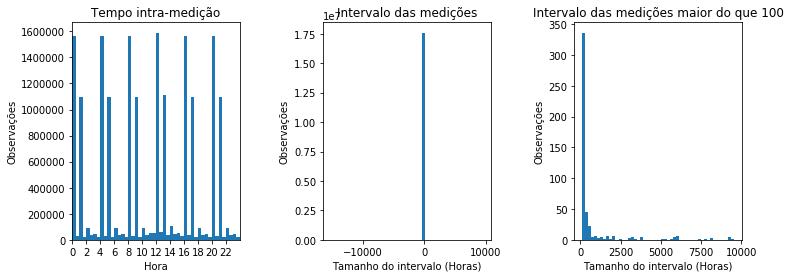

In [13]:
plotHist(df['TIME'], df['INTERVAL'])

Tempo intra-medição: A maoria dos reports acontecem em um intervalo de 4 horas, mas com duas sequências: (1) 0, 4, 8, 12, 16, and 20 horas e (2) 1, 5, 9, 13, 17, and 21 horas

Intervalo das medições: alguns intervalos excedem o padrão de 4 horas, entretanto parte desses possuem mais 100 horas, possivelmente essa diferença é resultante da diferença de tempo da última amostra de uma catraca e a primeira amostra da próxima catraca.

Concluiu-se que a maioria das medições ocorrem a cada 4 horas, logo medições realizadas fora do intervalo de 3,5 a 4,5 horas serão excluídas.

In [14]:
df = calc_diff(df)

In [15]:
df.describe()

,ENTRIES,EXITS,INTERVAL,ENTRY_DIFF,EXIT_DIFF
count,17591986,17591986,17591986,17591985,17591985
mean,36481891,29232859,0 days 03:59:27.914465,-0,-0
std,198575782,178482906,0 days 09:15:31.070662,5488296,5091223
min,0,0,0 days 00:00:00,-2147369278,-2097169658
25%,543990,272468,0 days 04:00:00,10,8
50%,2619784,1502162,0 days 04:00:00,75,51
75%,6650820,4699846,0 days 04:00:00,244,163
max,2147483520,2097169792,398 days 04:00:00,2145947875,2088918777




Supondo que:

1. uma pessoa leva em média 1 segundo para passar em uma catraca, no período de 4 horas teríamos no máximo 14.400 entradas

2. não existe a possibilidade da diferença entre duas medições sequenciais da mesma catraca ser negativa
    
Serão excluídos valores de entrada intra-período maior do que 14.400 + 30% (18.720).

Considerando que a saída é mais rápida, será adotado 0.5 segundos por pessoa, sendo o valor intra-período delimitado para exclusão de 28.800 + 30% (37.440).

# 3. Tratando inconsistências

In [16]:
df = check_exc_incos(df)

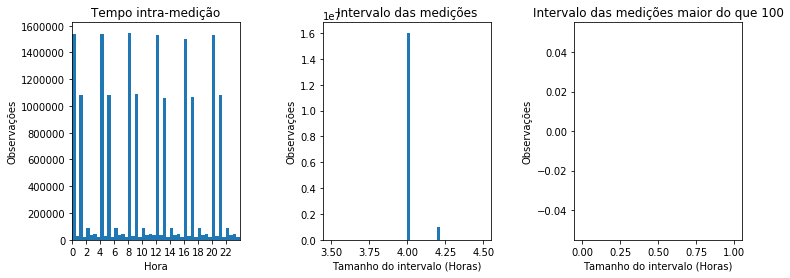

In [17]:
plotHist(df['TIME'], df['INTERVAL'])

É possível observar a atualização dos gráficos após a realização dos filtros.

In [18]:
df.shape

(17082775, 17)

In [19]:
df.describe()

,ENTRIES,EXITS,INTERVAL,ENTRY_DIFF,EXIT_DIFF
count,17082775,17082775,17082775,17082775,17082775
mean,27158172,20006289,0 days 04:00:40.852228,180,137
std,160752688,138130346,0 days 00:03:00.792916,261,233
min,0,0,0 days 03:30:01,0,0
25%,531738,264999,0 days 04:00:00,11,8
50%,2567294,1469630,0 days 04:00:00,78,52
75%,6485350,4575190,0 days 04:00:00,247,165
max,2147481984,2097169792,0 days 04:29:54,18604,35915


Com o tratamento das inconsistências realizado, será gerado um novo dataset agrupado por data

In [20]:
df1 = df.groupby('DATE').sum()

del df
gc.collect() 

14247

In [21]:
df1.to_csv('df_sum.csv', sep=';', encoding='utf-8')
#df1 =  pd.read_csv('df_sum.csv', sep=';', encoding='utf-8')
df = df1

In [22]:
df.head()

,ENTRIES,EXITS,ENTRY_DIFF,EXIT_DIFF
DATE,,,,
2016-01-01,460338547564,346615350120,1553318,1320178
2016-01-02,697684482633,523483810824,2798277,2243666
2016-01-03,689081100648,511894993823,2919319,2338575
2016-01-04,678598050434,508793522294,4310394,3260352
2016-01-05,620092526176,466587670959,5105345,3753380


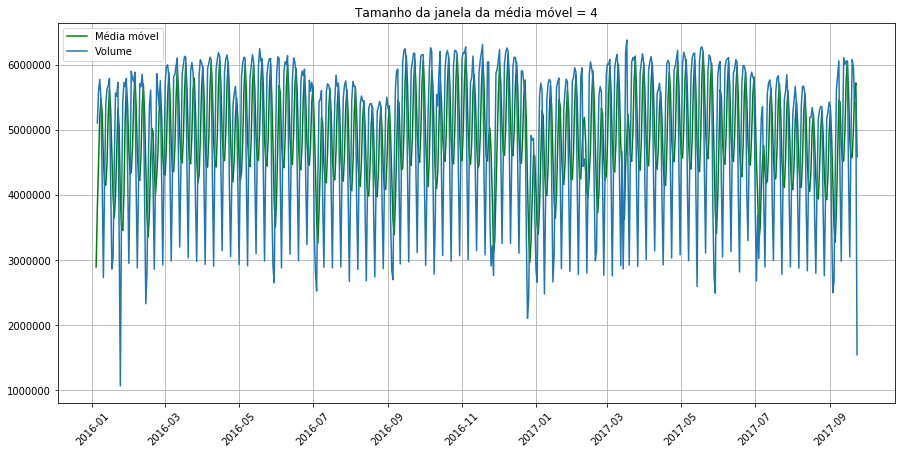

In [23]:
plotMovingAverage(df.ENTRY_DIFF, 4) 

É possível observar que não houve variações significativas no volume de entrada no período de jan-2016 até set-2017.

# 4. Feature engineering

O processo de feature engineering seguirá os seguintes procedimentos:
1. Criação de colunas com dia do mês, dia da semana, final de semana e feirado
2. Criação de colunas deslocando a variável target de 1 a 30 passos anteriores
3. Exclusão das variáveis com mais de 85% de correlação

In [24]:
df = feat_eng(df)

In [25]:
df.head()

,y,day,is_weekend,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
DATE,,,,,,,,,,,,,,,,,,
2016-01-01,1553318,1,0,0,0,0,0,1,0,0,1,nan,nan,nan,nan,nan,nan,nan
2016-01-02,2798277,2,1,0,0,0,0,0,1,0,0,1553318,nan,nan,nan,nan,nan,nan
2016-01-03,2919319,3,1,0,0,0,0,0,0,1,0,2798277,1553318,nan,nan,nan,nan,nan
2016-01-04,4310394,4,0,1,0,0,0,0,0,0,0,2919319,2798277,1553318,nan,nan,nan,nan
2016-01-05,5105345,5,0,0,1,0,0,0,0,0,0,4310394,2919319,2798277,1553318,nan,nan,nan


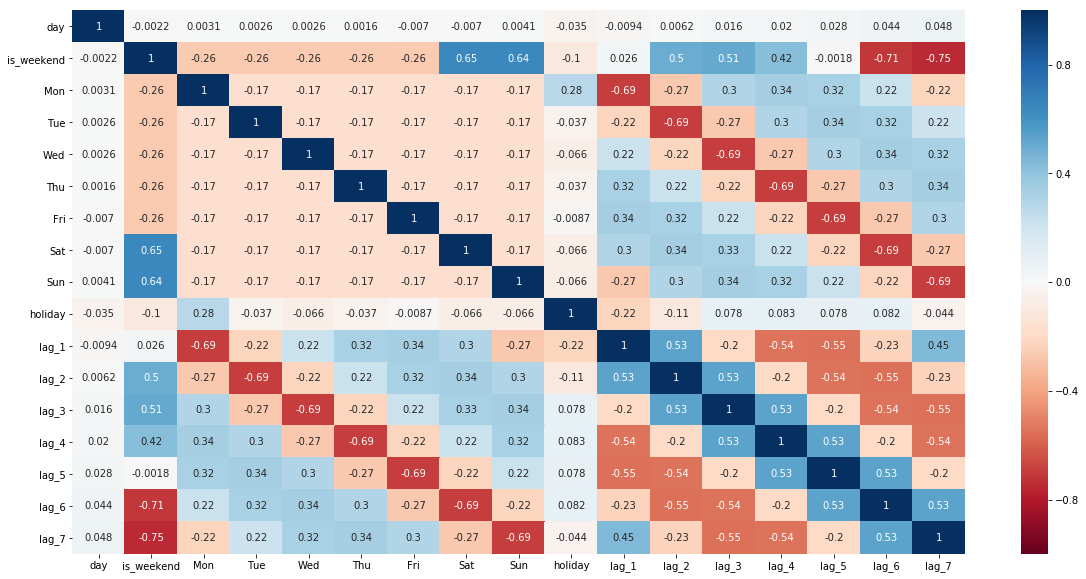

In [26]:
plt.figure(figsize=(20,10))
sns.heatmap(df.drop(['y'], axis=1).corr(), vmin=-1, cmap='RdBu', annot=True)

# 5. Construção do Modelo

O processo de construção do modelo seguirá os seguintes procedimentos:
1. Modelo: utilização de regressão linear
2. Dados: divisão dos dados entre treino e teste respeitando a estrutura de tempo e evitando vazamento de dados
3. Métrica de avaliação: utilização da métrica MAE (Mean Absolute Error)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [41]:
def timeseries_train_test_split(X, y, test_size, days_avoid_leak = 30):
    """
        Dividindo os dados em treino e teste
    """
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index - days_avoid_leak]
    y_train = y.iloc[:test_index - days_avoid_leak]
    X_test = X.iloc[test_index + days_avoid_leak:]
    y_test = y.iloc[test_index + days_avoid_leak:]
    
    return X_train, X_test, y_train, y_test

Retirando valores nulos das origindas do descolamento da variável target e dividindo os dados em treino e teste

In [42]:
y = df.dropna().y
X = df.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

Padronizando os dados

In [43]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Criando e treinando o modelo

In [44]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
#média dos últimos 60 dias do treino
mean_train = np.array([y_train[-60:].mean()] * y_test.size)

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))


def plotLRresults(model, X_train=X_train, X_test=X_test, mean_train=mean_train):
    """
        Apresentando a predição vs o valor verdadeiro
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "--g", label="predict_model", linewidth=2.0)
    plt.plot(mean_train, "--y", label="predict_mean_train", linewidth=2.0)
    plt.plot(y_test.values, label="y_true", linewidth=1.5)
    
    error_perc = mean_absolute_percentage_error(prediction, y_test)
    error_num = mean_absolute_error(prediction, y_test)
    error_mean = mean_absolute_percentage_error(mean_train, y_test)
        
    plt.title('Predição do modelo - Mean absolute percentage error {0:.2f}%'.format(error_perc) +\
              ' ({0:.2f})'.format(error_num) +\
              ' | Predição pela média do treino - Mean absolute percentage error {0:.2f}%'.format(error_mean)) 
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    
def plotLRcoefficients(model):
    """
        Apresentando os valores dos coeficientes do modelo 
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    plt.title('Valor dos Coeficientes')
    coefs.coef.plot(kind='bar')
  
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    plt.show()
 

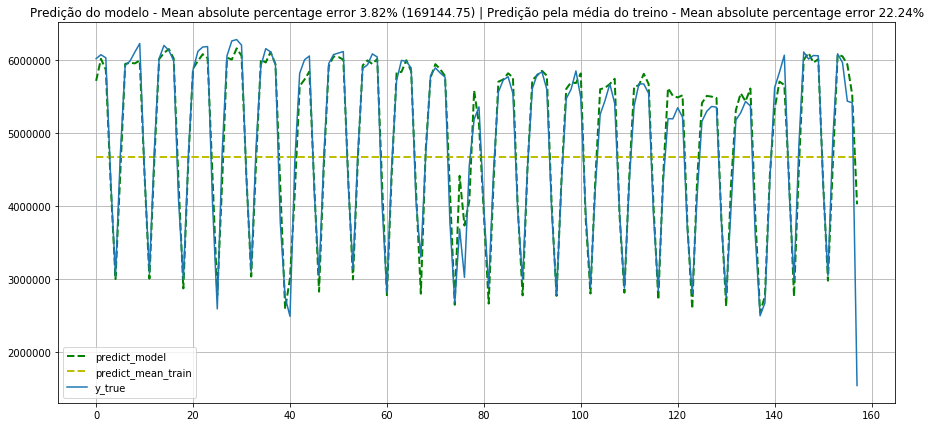

In [64]:
plotLRresults(lr, X_train=X_train_scaled, X_test=X_test_scaled)

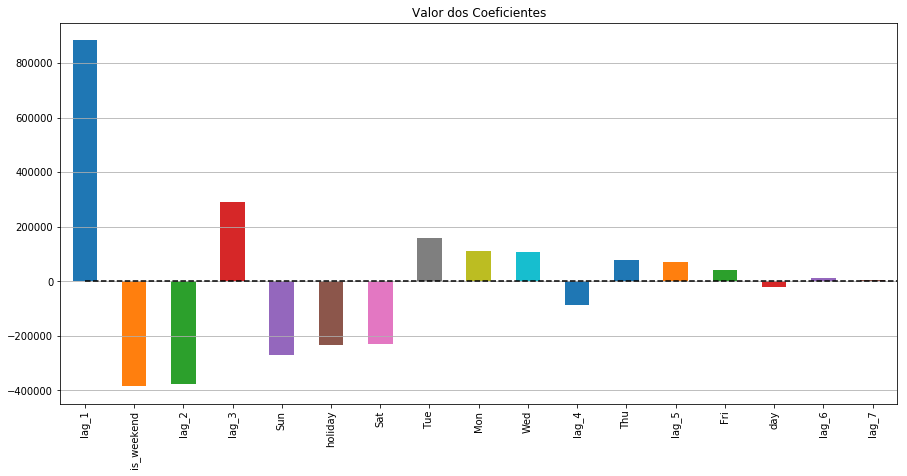

In [65]:
plotLRcoefficients(lr)

# 6. Conclusão

Podemos observar que o modelo de Regressão Linear obteve um resultado satisfatório, mesmo sendo utilizado em um problema de série temporal.

Devido à inconsistências encontradas na base de dados foi necessário manipulação, tratamentos dos dados e filtros baseados em algumas hipóteses. 

As variáveis criadas no processo de feature engineering se mostraram relevantes para a predição do modelo, proporcionando um MAE de 169.145 (~3.82%).

O processo de análise exploratória poderia ser aprofundado com outras visões, mas devido ao prazo de entrega não foi continuado.